In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

/Users/emilyhoughkovacs/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

###Want something like:

In [3]:
def makeSQLQuery(table_names, year, seriesnames):
    dotyyear = '.y' + str(year)
    short = table_names[0][0:2]
    seriesnames = seriesnames
    abb = [ser[0:2] for ser in seriesnames]
    query = 'SELECT x.*, y' + dotyyear + ' as zscores FROM (' + \
            'SELECT ' + short + '.countrycode AS countrycode, ' + \
            short + dotyyear + ' AS ' + table_names[0] 
    
    mystr = ''
    for s in seriesnames:
        mystr = mystr + ', env.' + s
    mystr = mystr
    
    query = query + mystr
    
    query = query + ' FROM (SELECT countrycode, ' + dotyyear[1:] + \
        ' FROM ' + table_names[0] + ') ' + short + ' JOIN ' + \
        '(SELECT ' + abb[0] + '.countrycode AS countrycode'
    
    mystr = ''
    for a, ser in zip(abb, seriesnames):
        mystr = mystr + ', ' + a + dotyyear + ' as ' + ser
    query = query + mystr
    
    query = query + ' FROM ('
    
    subquery = []
    for a, ser in zip(abb, seriesnames):
        mystr = ''
        mystr = mystr + '(SELECT countrycode, ' + dotyyear[1:] + \
        ' FROM ' + table_names[1] + " WHERE series='" + ser + \
        "') " + a
        subquery.append(mystr)
    
    query = query + subquery[0] + ' JOIN ' + subquery[1] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[1] + '.countrycode' + \
        ' JOIN ' + subquery[2] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[2] + '.countrycode' + \
        ' JOIN ' + subquery[3] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[3] + '.countrycode)) env' + \
        ' ON ' + short + '.countrycode = env.countrycode'
        
    query = query + ') x JOIN (select countrycode, ' + dotyyear[1:] + \
            ' FROM zscores) y on x.countrycode = y.countrycode'
    
    return query

In [4]:
years = [x for x in range(1990, 2001)]
years2 = [x for x in range(2006, 2015)]
years = years + years2

In [5]:
tables = ['forestarea', 'environment']

In [6]:
features = ['precipitation', 'extreme', 'arable_land', 'freshwater']

In [7]:
print makeSQLQuery(tables, years[0], features)

SELECT x.*, y.y1990 as zscores FROM (SELECT fo.countrycode AS countrycode, fo.y1990 AS forestarea, env.precipitation, env.extreme, env.arable_land, env.freshwater FROM (SELECT countrycode, y1990 FROM forestarea) fo JOIN (SELECT pr.countrycode AS countrycode, pr.y1990 as precipitation, ex.y1990 as extreme, ar.y1990 as arable_land, fr.y1990 as freshwater FROM ((SELECT countrycode, y1990 FROM environment WHERE series='precipitation') pr JOIN (SELECT countrycode, y1990 FROM environment WHERE series='extreme') ex ON pr.countrycode = ex.countrycode JOIN (SELECT countrycode, y1990 FROM environment WHERE series='arable_land') ar ON pr.countrycode = ar.countrycode JOIN (SELECT countrycode, y1990 FROM environment WHERE series='freshwater') fr ON pr.countrycode = fr.countrycode)) env ON fo.countrycode = env.countrycode) x JOIN (select countrycode, y1990 FROM zscores) y on x.countrycode = y.countrycode


In [8]:
df = pd.DataFrame()

In [9]:
for year in years:
    query = makeSQLQuery(tables, year, features)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['countrycode', 'year'])
    df = pd.concat([df, year_data])

In [10]:
df.head()

,,forestarea,precipitation,extreme,arable_land,freshwater,zscores
countrycode,year,,,,,,
ARG,1990,12.713534,591,0.167190,9.71064,8676.235544,-0.220411542
AUS,1990,16.732098,534,3.047099,6.23511,28122.320663,None
BRA,1990,65.409888,1761,0.482451,6.06367,36433.492763,-0.220597981
CHN,1990,16.738008,645,7.950971,13.1867,2414.654455,-0.220576536
FRA,1990,26.363945,867,0.005718,32.4797,3398.400468,None


In [11]:
df.tail()

,,forestarea,precipitation,extreme,arable_land,freshwater,zscores
countrycode,year,,,,,,
UZB,2014,7.621392,206,0.123694,None,540.286742,-0.235228733
VEN,2014,53.298339,2044,0.155204,None,26588.677616,-0.228847937
VNM,2014,46.812010,1821,1.599362,None,4006.291460,-0.034788813
YEM,2014,1.039832,167,0.099411,None,82.245806,-0.238605007
ZMB,2014,65.871481,1020,4.199677,None,5260.366497,-0.243482678


In [12]:
df[df.isnull().any(axis=1)].size

2430

In [13]:
df.head().swaplevel(0, 1, axis=0)

forestarea  precipitation   extreme arable_land  \
year countrycode                                                    
1990 ARG           12.713534            591  0.167190     9.71064   
     AUS           16.732098            534  3.047099     6.23511   
     BRA           65.409888           1761  0.482451     6.06367   
     CHN           16.738008            645  7.950971     13.1867   
     FRA           26.363945            867  0.005718     32.4797   

                    freshwater       zscores  
year countrycode                              
1990 ARG           8676.235544  -0.220411542  
     AUS          28122.320663          None  
     BRA          36433.492763  -0.220597981  
     CHN           2414.654455  -0.220576536  
     FRA           3398.400468          None

In [154]:
#get yearly data by country
df.xs('ARG', level='countrycode', axis=0).head()
df.loc['ARG'].head()

,forestarea,precipitation,extreme,arable_land,freshwater,zscores
year,,,,,,
1990,12.713534,591,0.16719,9.71064,8676.235544,-0.220411542
1991,12.606360,591,0.16719,9.749,8676.235544,-0.240598079
1992,12.499187,591,0.16719,9.78737,8676.235544,-0.315149285
1993,12.392014,591,0.16719,9.82574,8676.235544,-0.316487036
1994,12.284840,591,0.16719,9.8652,8676.235544,-0.258949066


In [155]:
# get country-level data by year
df.xs(2013, level='year', axis=0).head()

,forestarea,precipitation,extreme,arable_land,freshwater,zscores
countrycode,,,,,,
ARG,10.123763,591,0.167190,14.5062,6864.401552,-0.26509832
AUS,16.158572,534,3.047099,6.0163,21274.877120,-0.265693695
BRA,59.284243,1761,0.482451,9.0939,27714.761903,-0.265421506
CHN,21.861130,645,7.950971,11.2609,2072.374722,-0.254964769
FRA,30.614164,867,0.005718,33.4316,3033.727557,-0.26567294


In [14]:
df['zscores'] = df['zscores'].astype(float)

In [19]:
# df.loc[df['zscores'] > 0, 'zscores'] = 1
# df.loc[df['zscores'] <= 0, 'zscores'] = 0
df['binary'] = df['zscores'].apply(lambda x: 1 if x > 0 else 0)

In [15]:
# just drop these for now! fix tmr!
df[df.isnull().any(axis=1)].size

2430

In [20]:
df = df.dropna()

In [21]:
x_cols = ['forestarea', 'precipitation', 'extreme', 'arable_land', 'freshwater']

In [22]:
# convert each feature to z-score to normalize
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

In [43]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred) 
    
    scores = pd.Series(data=[accuracy_score_value, precision_score_value, recall_score_value, f1_score_value],
                      index=["Accuracy", "Precision", "Recall", "F1"])
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
        
#     fimp = pd.Series(data=feature_importances, index=x_cols)
    
#     if verbose:
#         #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
#         print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
#                                                                        precision_score_value, \
#                                                                        recall_score_value, \
#                                                                        f1_score_value))
    
    return scores

In [26]:
X = df[x_cols]
y = df['binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [27]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.955259975816
Precision: 0.811594202899
Recall: 0.910569105691
f1: 0.858237547893


(Accuracy     0.955260
 Precision    0.811594
 Recall       0.910569
 F1           0.858238
 dtype: float64, forestarea       0.200158
 precipitation    0.113569
 extreme          0.204267
 arable_land      0.220260
 freshwater       0.261746
 dtype: float64)

In [28]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.851269649335
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/emilyhoughkovacs/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/emilyhoughkovacs/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(Accuracy     0.85127
 Precision    0.00000
 Recall       0.00000
 F1           0.00000
 dtype: float64, forestarea      NaN
 precipitation   NaN
 extreme         NaN
 arable_land     NaN
 freshwater      NaN
 dtype: float64)

In [29]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.851269649335
Precision: 0.0
Recall: 0.0
f1: 0.0


(Accuracy     0.85127
 Precision    0.00000
 Recall       0.00000
 F1           0.00000
 dtype: float64, forestarea      NaN
 precipitation   NaN
 extreme         NaN
 arable_land     NaN
 freshwater      NaN
 dtype: float64)

In [30]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.863361547763
Precision: 1.0
Recall: 0.0813008130081
f1: 0.15037593985


(Accuracy     0.863362
 Precision    1.000000
 Recall       0.081301
 F1           0.150376
 dtype: float64, forestarea      NaN
 precipitation   NaN
 extreme         NaN
 arable_land     NaN
 freshwater      NaN
 dtype: float64)

In [31]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.967351874244
Precision: 0.887096774194
Recall: 0.894308943089
f1: 0.890688259109


(Accuracy     0.967352
 Precision    0.887097
 Recall       0.894309
 F1           0.890688
 dtype: float64, forestarea       0.219603
 precipitation    0.135933
 extreme          0.186335
 arable_land      0.191712
 freshwater       0.266416
 dtype: float64)

In [32]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
#     print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='AUC: %0.3f' % auc)

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('False Postive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Random Forest ROC Curve for Climate-Triggered Refugee Disasters', fontsize=16)
    plt.legend(loc='best', fontsize=14)

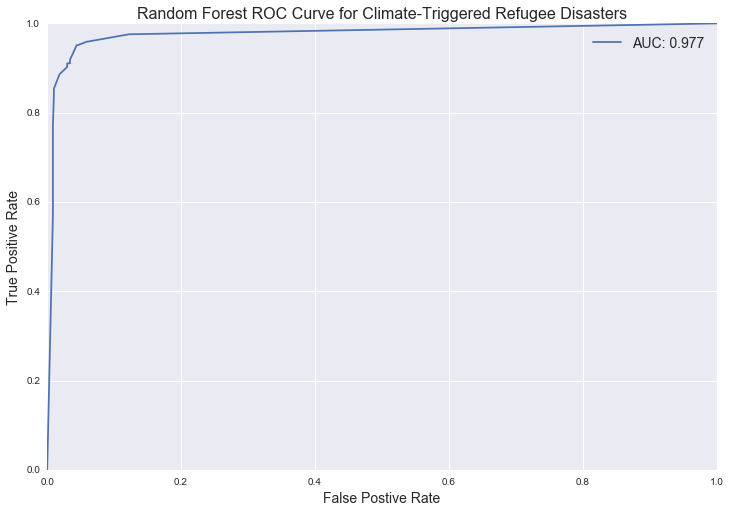

In [36]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [40]:
X_trainsmall, X_testsmall, y_trainsmall, y_testsmall = train_test_split(df[['forestarea', 'arable_land']], df['binary'], test_size = .30, random_state=4444)

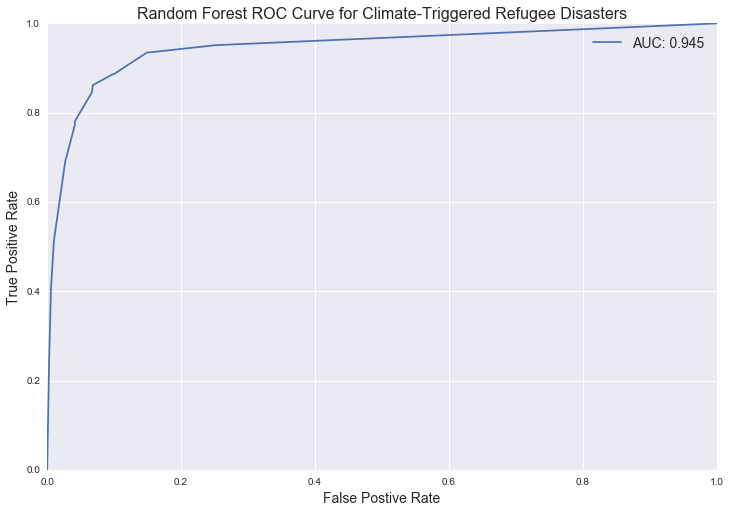

In [41]:
getROCcurve(X_trainsmall, X_testsmall, y_trainsmall, y_testsmall, model=RandomForestClassifier())

In [44]:
getScoreValues(X_trainsmall, X_testsmall, y_trainsmall, y_testsmall, model=RandomForestClassifier())

Accuracy     0.927449
Precision    0.805825
Recall       0.674797
F1           0.734513
dtype: float64

In [45]:
newdf = df[['forestarea', 'arable_land', 'binary']]

In [46]:
newdf

,,forestarea,arable_land,binary
countrycode,year,,,
ARG,1990,-0.796996,-0.441868,0
BRA,1990,1.527929,-0.702268,0
CHN,1990,-0.619439,-0.193671,0
IND,1990,-0.409115,2.79028,0
IDN,1990,1.529157,-0.336966,0
RUS,1990,0.819664,-0.56014,0
ARM,1990,-0.820170,-0.0743546,0
TUR,1990,-0.806324,1.15138,0
GBR,1990,-0.851301,0.818564,0
